In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
file_path = Path("visa.csv")
visa = pd.read_csv(file_path)

#"case_status"
visa.loc[visa.case_status=="Certified", "case_status"]=1
visa.loc[visa.case_status=="Denied", "case_status"]=0
visa["case_status"]=visa["case_status"].astype(str).astype(int)


visa.head()

,Unnamed: 0,case_number,case_received_year,case_status,class_of_admission,decision_year,employer_country,employer_name,employer_num_employees,employer_state,...,job_info_experience,job_info_foreign_ed,job_info_foreign_lang_req,job_info_job_title,job_info_training,pw_amount_9089,pw_job_title_9089,pw_level_9089,pw_source_name_9089,pw_unit_of_pay_9089
0,135269,A-13316-14231,2013,1,H-1B,1432857600000000000,UNITED STATES OF AMERICA,GENERAC POWER SYSTEMS,1935,WI,...,N,Y,N,Senior Engineer,N,83366.0,Industrial Engineers,Level IV,OES,Year
1,135270,A-13316-14287,2013,0,H-1B,1435276800000000000,UNITED STATES OF AMERICA,"AMERICA'S CATCH, INC.",350,MS,...,N,N,N,Catfish Processor,N,16973.0,"Meat, Poultry, and Fish Cutters and Trimmers",Level I,OES,Year
2,135271,A-13316-14312,2013,0,H-1B,1413417600000000000,UNITED STATES OF AMERICA,"AVIDITY, LLC",4,CO,...,Y,Y,N,Protein Production Scientist,N,49982.0,Protein Production Scientist,Level I,OES,Year
3,135272,A-13316-14276,2013,1,E-2,1432598400000000000,UNITED STATES OF AMERICA,STAR COMMUNICATIONS LLC,8,WA,...,N,Y,N,Market Research Analyst,N,43514.0,Market Research Analysts and Marketing Special...,Level I,OES,Year
4,135273,A-13316-14275,2013,0,H-1B,1435276800000000000,UNITED STATES OF AMERICA,"AMERICA'S CATCH, INC.",350,MS,...,N,N,N,Catfish Processor,N,16973.0,"Meat, Poultry, and Fish Cutters and Trimmers",Level I,OES,Year


### Convert categorical features to dummy variables 

In [4]:
class_of_admission = pd.get_dummies(visa["class_of_admission"],drop_first=True)
foreign_worker_info_education = pd.get_dummies(visa["foreign_worker_info_education"],drop_first=True)
country_of_citizenship = pd.get_dummies(visa["country_of_citizenship"],drop_first=True)
fw_info_rel_occup_exp = pd.get_dummies(visa["fw_info_rel_occup_exp"],drop_first=True)
fw_info_req_experience = pd.get_dummies(visa["fw_info_req_experience"],drop_first=True)
job_info_education = pd.get_dummies(visa["job_info_education"],drop_first=True)
job_info_experience = pd.get_dummies(visa["job_info_experience"],drop_first=True)
job_info_training = pd.get_dummies(visa["job_info_training"],drop_first=True)

In [5]:
visa.drop(["class_of_admission","foreign_worker_info_education","country_of_citizenship",
          "fw_info_rel_occup_exp","fw_info_req_experience","job_info_education","job_info_experience",
          "job_info_training","pw_level_9089","case_number","employer_country","employer_name","employer_state",
          "foreign_worker_info_major","foreign_worker_info_state","fw_info_alt_edu_experience","fw_info_birth_country",
          "job_info_foreign_ed","job_info_foreign_lang_req","job_info_job_title","pw_job_title_9089","pw_source_name_9089",
          "pw_unit_of_pay_9089"],axis=1,inplace=True)

In [6]:
visa=pd.concat([visa,class_of_admission,foreign_worker_info_education,country_of_citizenship,
          fw_info_rel_occup_exp,fw_info_req_experience,job_info_education,job_info_experience,
          job_info_training],axis=1)

In [7]:
visa.head()

,Unnamed: 0,case_received_year,case_status,decision_year,employer_num_employees,employer_yr_estab,job_info_alt_occ_num_months,pw_amount_9089,A1/A2,B-1,...,ZAMBIA,ZIMBABWE,Bachelor's,Doctorate,High School,Master's,None,Other,Y,Y
0,135269,2013,1,1432857600000000000,1935,1959.0,84.0,83366.0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,135270,2013,0,1435276800000000000,350,1988.0,60.0,16973.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,135271,2013,0,1413417600000000000,4,1996.0,60.0,49982.0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,135272,2013,1,1432598400000000000,8,2010.0,60.0,43514.0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,135273,2013,0,1435276800000000000,350,1988.0,60.0,16973.0,0,0,...,0,0,0,0,0,0,1,0,0,0


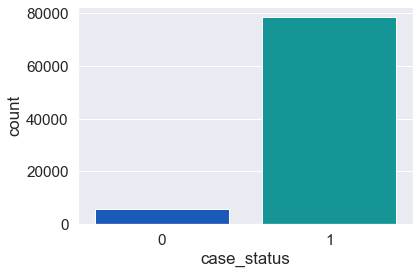

In [32]:
sns.countplot(x="case_status",data=visa, palette="winter")

In [9]:
y = visa["case_status"]
X = visa.drop(columns="case_status")

In [10]:
X.describe()

,Unnamed: 0,case_received_year,decision_year,employer_num_employees,employer_yr_estab,job_info_alt_occ_num_months,pw_amount_9089,A1/A2,B-1,B-2,...,ZAMBIA,ZIMBABWE,Bachelor's,Doctorate,High School,Master's,None,Other,Y,Y
count,84179.000000,84179.000000,8.417900e+04,8.417900e+04,84179.000000,84179.000000,8.417900e+04,84179.000000,84179.000000,84179.000000,...,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000,84179.000000
mean,178966.804155,2013.973010,1.429156e+18,2.197198e+04,1983.309543,47.012307,8.598948e+04,0.000345,0.001330,0.008256,...,0.000107,0.000558,0.390964,0.035603,0.012937,0.446750,0.074009,0.032455,0.551682,0.018330
std,25495.050330,0.705961,9.181104e+15,7.481748e+04,36.470322,20.987602,3.533220e+05,0.018558,0.036452,0.090488,...,0.010339,0.023623,0.487969,0.185299,0.113002,0.497159,0.261787,0.177205,0.497325,0.134143
min,135269.000000,2006.000000,1.412122e+18,0.000000e+00,1600.000000,0.000000,7.500000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,156979.500000,2014.000000,1.421798e+18,7.500000e+01,1980.000000,24.000000,6.651800e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,178527.000000,2014.000000,1.428970e+18,1.400000e+03,1994.000000,60.000000,8.403200e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,200644.500000,2014.000000,1.437696e+18,2.780000e+04,2004.000000,60.000000,1.036260e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,223902.000000,2015.000000,1.443571e+18,2.200000e+06,2015.000000,240.000000,1.010880e+08,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Check the balance of our target values
y.value_counts()

1    78622
0     5557
Name: case_status, dtype: int64

### Test-Train-Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split (X, y, random_state = 1, stratify=y)

X_train.shape

(63134, 246)

In [13]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train.values, y_train.values)
Counter(y_res)

Counter({1: 58966, 0: 58966})

In [14]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(random_state=1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

In [15]:
#from random_forest.fit(X_train,y_train.ravel())
#y_pred.summary()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [16]:
y_pred = logreg.predict(X_test)
print('log: ', metrics.accuracy_score(y_test, y_pred))

log:  0.06600142551674983


In [17]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5

In [18]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 1389,     0],
       [19656,     0]])

In [19]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      1.00      0.00      0.12      0.00      0.00      1389
          1       0.00      0.00      1.00      0.00      0.00      0.00     19656

avg / total       0.00      0.07      0.93      0.01      0.00      0.00     21045



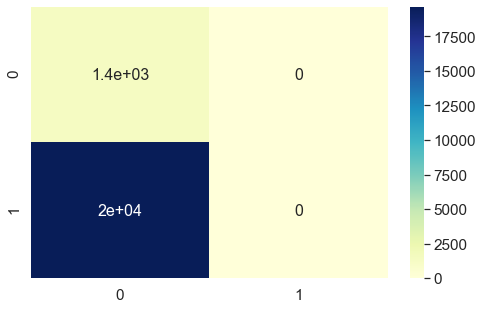

In [20]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size

### SMOTE Oversampling

In [21]:
# Resample the training data with SMOTE
X_res, y_res = SMOTE(random_state=1).fit_resample(X_train.values, y_train.values)
Counter(y_res)

Counter({1: 58966, 0: 58966})

In [22]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(random_state=1)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

In [23]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5

In [24]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 1389,     0],
       [19656,     0]])

In [25]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      1.00      0.00      0.12      0.00      0.00      1389
          1       0.00      0.00      1.00      0.00      0.00      0.00     19656

avg / total       0.00      0.07      0.93      0.01      0.00      0.00     21045



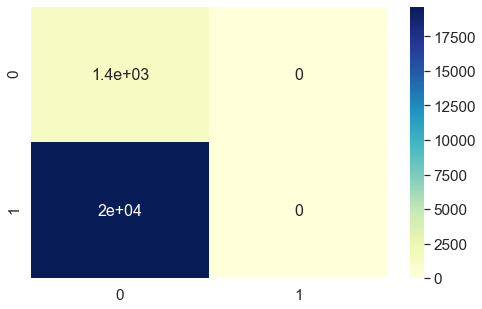

In [26]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size

## Ensemble Learners
### Balanced Random Forest Classifier

In [27]:
# Resample the training data with the BalancedRandomForestClassifier
random_forest_model = BalancedRandomForestClassifier(random_state=1)
random_forest_model = random_forest_model.fit(X_train.values, y_train.values)
y_pred = random_forest_model.predict(X_test)

In [28]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8372925770333978

In [29]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 1175,   214],
       [ 3368, 16288]])

In [30]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.26      0.85      0.83      0.40      0.84      0.70      1389
          1       0.99      0.83      0.85      0.90      0.84      0.70     19656

avg / total       0.94      0.83      0.84      0.87      0.84      0.70     21045



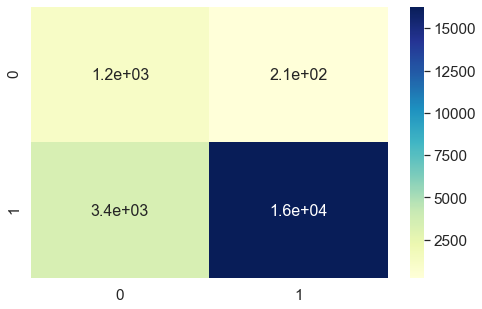

In [31]:
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size